This workbook is a run through of univariate modeling using ARIMA and SARIMAX. 
This will cover manually setting the hyperparameters 
Where this workbook will stop, is after using seasonal and non-seasonal ARIMA modeling.
The following workbook will cover multivariate ARIMA and SARIMAX and also SARIMAX-stepwise modeling.

In [20]:
import statsmodels
statsmodels.__version__

'0.13.2'

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path
import seaborn as sns

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5] 

In [22]:
import matplotlib 
import scipy 
import sklearn
import seaborn


print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
sklearn -> {sklearn.__version__}
seaborn -> {seaborn.__version__}
''')



Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
scipy -> 1.8.0
statsmodels -> 0.13.2
sklearn -> 1.0.2
seaborn -> 0.11.2



In [23]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score=v[c]
            best_model = k
            print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [24]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
        print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [25]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [31]:
def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [32]:
life = pd.read_csv('/Users/paul.carroll/Documents/datasets/USlifeexpenctancyBirth.csv',index_col = 'TIME')
life = life.Value
life = life.iloc[0:50]
milk = pd.read_csv('/Users/paul.carroll/Documents/datasets/monthlymilkproductionpounds.csv', index_col = 'Month')
rename_map = {'Monthly milk production: pounds per cow. Jan 62 ? Dec 75':'Monthly_milk_production'}

milk.rename(columns=rename_map, inplace=True)
milk= milk.iloc[0:168]

In [33]:
def plot_forecast(model, start, train, test):
    forecast=pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [34]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

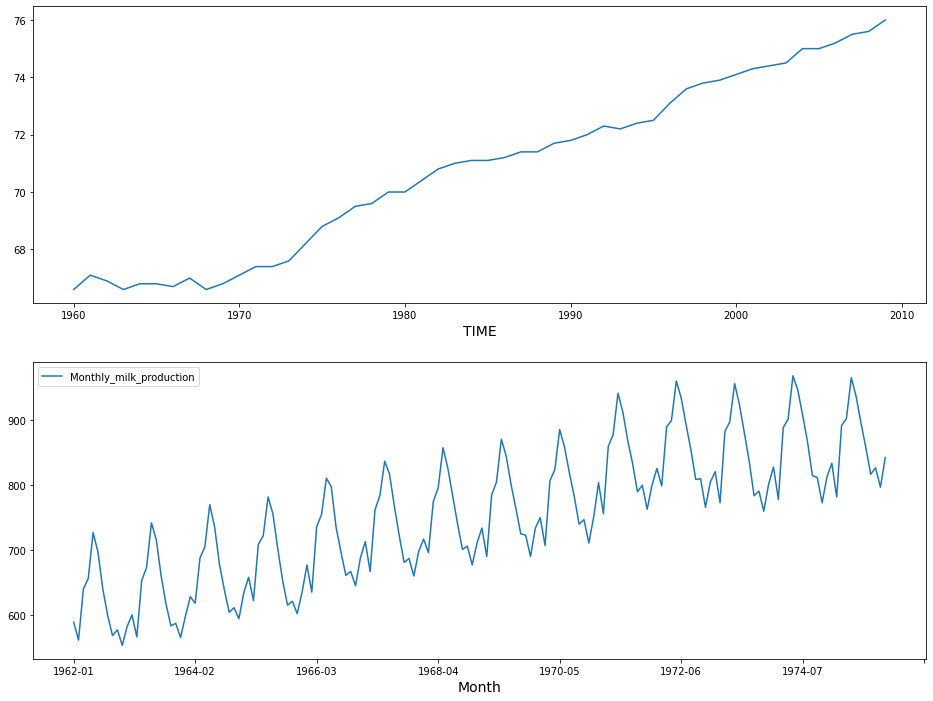

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(ax=ax[0])
milk.plot(ax=ax[1]);

In [36]:
test_split = 0.20
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)


train: 134 , test: 34
train: 40 , test: 10


In [37]:
life.head()

TIME
1960    66.6
1961    67.1
1962    66.9
1963    66.6
1964    66.8
Name: Value, dtype: float64

In [38]:
check_stationarity(milk)

('Non-Stationary', 0.627426708603029)

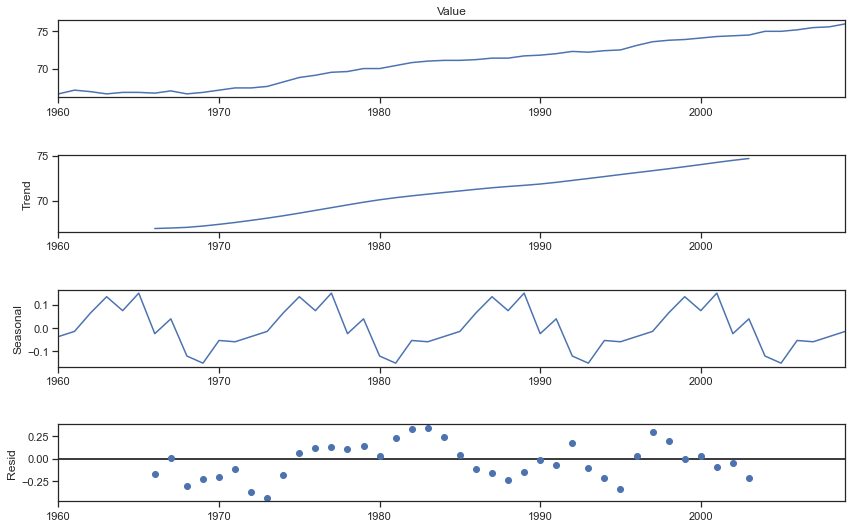

In [39]:
sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(life, period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();

In [40]:
check_stationarity(life)

('Non-Stationary', 0.9918590610034949)

There are three parts to the tuning of an ARIMA model, 4 to a SARIMAX. The parameters are (p,d,q).
The first stage with an ARIMA or SARIMAX model is to find the hyperparameter tunings, the p for AR, which is the auto-regressive part of the 'AR'IMA model. This value can be found from the PACF graph, which you run on the differenced univariate series of data. 
The d is the differencing order. The q is the MA part, the moving average which you obtain from the ACF graph. 
Below we will plot the ACF and PACF graphs to show you how to obtain these numbers. 

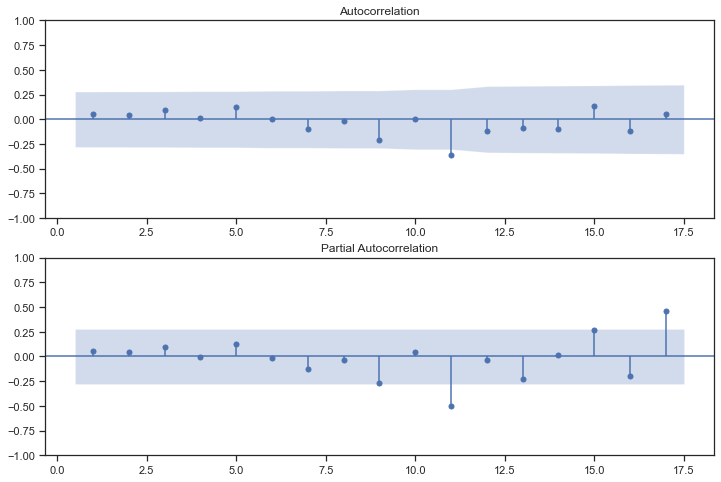

In [41]:
life_diff = life.diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show() 

In [42]:
#ACF plot shows significance at point 11, and PACF at 11 and 16.

In [44]:
#check stationarity of the life differenced dataset. Now this is < 0.05 can say data is now stationary.
check_stationarity(life_diff)

'Stationary	 p-value:0.003259178221138927 	 lags:10


('Stationary', 0.003259178221138927)

so ACF value here gives 11, 1 for d, and MA value from ACF of 11, so (11,1,11) for ARIMA

In [47]:
from statsmodels.tsa.arima.model import ARIMA
life_modelA = ARIMA(life.diff(), order =(11,1,11)).fit()

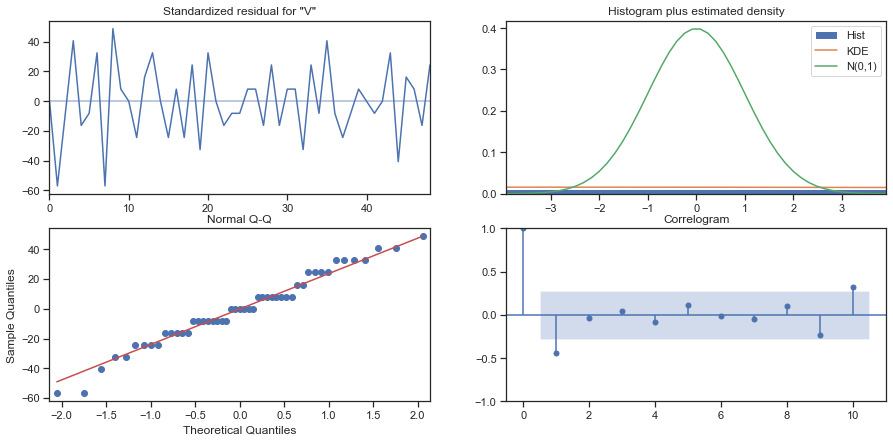

In [48]:
life_modelA.plot_diagnostics(figsize=(15,7)); plt.show()

In [49]:
life_modelB = ARIMA(life.diff(), order = (1,1,1)).fit()

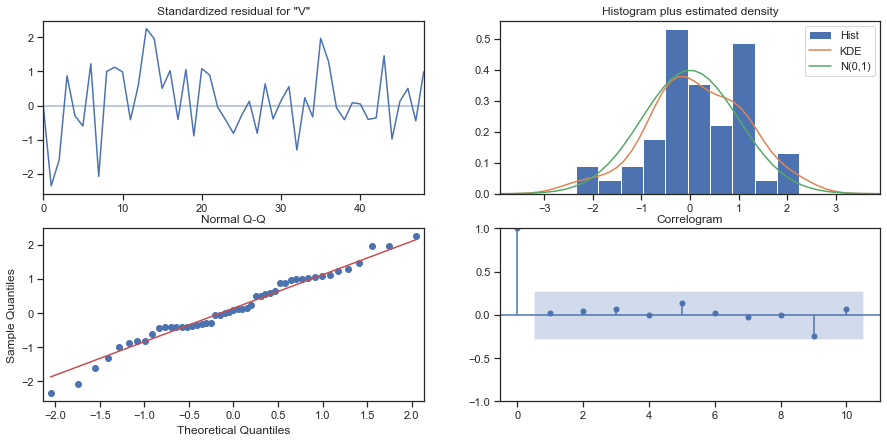

In [50]:
life_modelB.plot_diagnostics(figsize=(15,7)); plt.show()

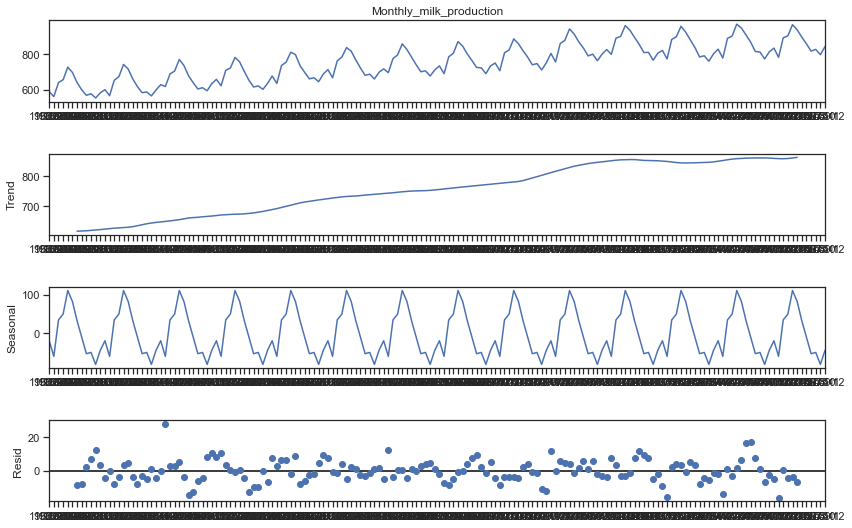

In [60]:
sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(milk.Monthly_milk_production, period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();

In [61]:
#Differencing the milk dataset by 12, as from the seasonal_decompose the trend is annual. 
milk_diff_12 = milk.diff(12).dropna()

In [62]:
check_stationarity(milk_diff_12)
#however this is still not stationary.

('Non-Stationary', 0.16079880527711332)

In [63]:
milk_diff_12_1= milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.8654234318788898e-05 	 lags:11


('Stationary', 1.8654234318788898e-05)

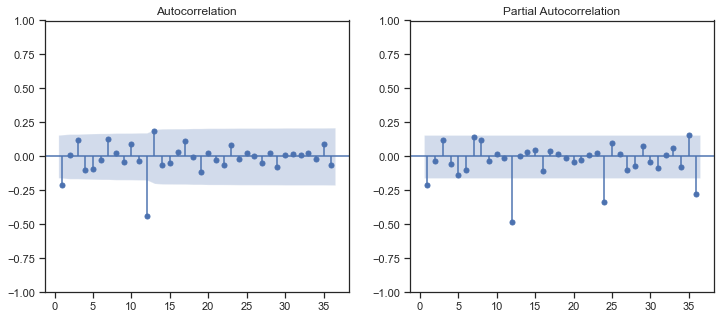

In [64]:
fig, ax= plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False,
         ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1,zero=False,
          ax=ax[1], lags=36)
plt.show();


In [65]:
milk.dtypes

Monthly_milk_production    float64
dtype: object

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [72]:
#fitting a seasonal ARIMA model, SARIMAX, with p, d, q as 1,1,0 and 12 as S.
model = SARIMAX(milk, order =(0,1,1), seasonal_order=(0,1,1,12)).fit(disp=False)


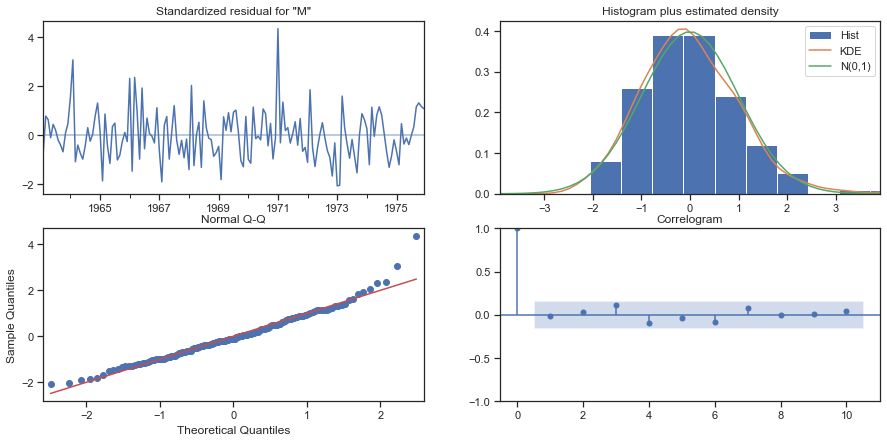

In [73]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [74]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Monthly_milk_production   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -530.148
Date:                            Fri, 09 Sep 2022   AIC                           1066.296
Time:                                    15:58:16   BIC                           1075.427
Sample:                                01-01-1962   HQIC                          1070.005
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2204      0.076     -2.898      0.004      -0.369      -0.071
ma.S.L12      -0.6214      0.070     -8.872      0.000      -0.759      -0.484
sigma2        52.7040      4.966     10.613      0.000      42.971      62.437
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                33.65
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.74
Prob(H) (two-sided):                  0.51   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
#plot_forecast(model,'1971',milk_train, milk_test)

In [77]:
milk_train

,Monthly_milk_production
Month,
1962-01,589.0
1962-02,561.0
1962-03,640.0
1962-04,656.0
1962-05,727.0
...,...
1972-10,810.0
1972-11,766.0
1972-12,805.0


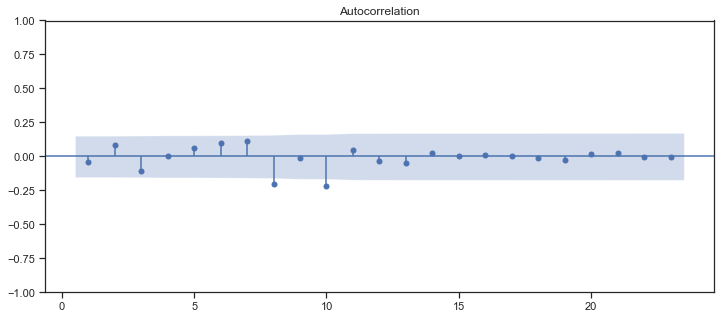

In [78]:
plot_acf(model.resid[1:], zero=False)
plt.show();

In [79]:
from statsmodels.tsa.arima.model import ARIMA
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(milk_train, order=(p,d,q))
    res = m.fit()
    y = milk_train.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                    'AIC':res.aic,
                    'RMSPE': rmspe(y, y_hat),
                    'BIC': res.bic,
                    'AICc':res.aicc,
                    'RMSE' : rmse(y, y_hat),
                    'MAPE' : mape(y, y_hat),
                    'model': res}

In [80]:
best_m = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: 1493.660301022369
Best model: 2 with lowest AIC score: 1435.5111720600282
Best model: 3 with lowest AIC score: 1386.8087460211007
Best model: 5 with lowest AIC score: 1371.752986832229
Best model: 23 with lowest AIC score: 1363.6460437271764
Best model: 26 with lowest AIC score: 1351.1813427822208


In [83]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,26,"(2, 2, 2)",1351.181343,27.122707,1365.595352,1351.657533,2131.709514,2.358453,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,23,"(2, 1, 2)",1363.646044,1.468584,1378.097789,1364.118485,97.231957,0.116729,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,5,"(0, 1, 2)",1371.752987,1.427904,1380.424034,1371.939033,95.790503,0.114087,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,14,"(1, 1, 2)",1372.512137,1.428924,1384.073534,1372.824637,95.803219,0.114188,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,11,"(1, 0, 2)",1372.700005,1.336853,1387.189204,1373.168755,93.921706,0.10878,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [84]:
from statsmodels.tsa.api import ExponentialSmoothing

In [85]:
trend = ['add', 'mul']
damped = [True,False]
life_ex_comb = combinator([trend, damped])
life_ex_comb


[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [93]:
# Exponential Smoothing with Seasonal flag turned off 
train = life_train.values.ravel()
y=life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp= ExponentialSmoothing(train, 
                              trend=t,
                              damped_trend=-dp,
                              seasonal=None)
    model=exp.fit(use_brute=True,
                  optimized=True)
    y_hat = model.forecast(len(y))
    score[i]= {'trend':t,
               'damped':dp,
               'AIC':model.aic,
               'BIC':model.bic,
               'AICc':model.aicc,
               'RMSPE': rmspe(y,y_hat),
               'RMSE':rmse(y,y_hat),
               'MAPE':mape(y,y_hat),
               'model':model}

In [114]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,3,mul,False,-110.436402,-103.680884,-107.890948,0.013486,0.101019,0.00109,<statsmodels.tsa.holtwinters.results.HoltWinte...
1,1,add,False,-110.191488,-103.43597,-107.646033,0.01437,0.108298,0.001054,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,2,mul,True,-107.74097,-99.296573,-104.24097,0.236512,1.783678,0.021152,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,0,add,True,-107.398468,-98.95407,-103.898468,0.029332,0.22178,0.00228,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [94]:
life_best_model = get_best_model(score,'AIC')

Best model: 1 with lowest AIC score: -110.19148776211877
Best model: 3 with lowest AIC score: -110.4364021767594


In [95]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,40
Model:,ExponentialSmoothing,SSE,2.071
Optimized:,True,AIC,-110.436
Trend:,Multiplicative,BIC,-103.681
Seasonal:,None,AICC,-107.891
Seasonal Periods:,None,Date:,"Fri, 09 Sep 2022"
Box-Cox:,False,Time:,16:09:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,1.798e-11,beta,True


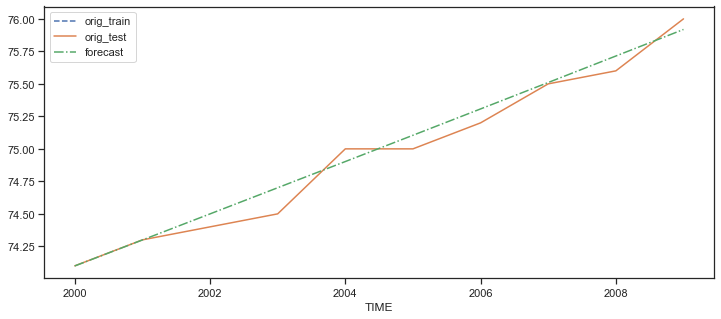

In [96]:
plot_forecast(life_best_model,'2000',
              life_train,life_test)

In [97]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [101]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train,
                               trend=t,
                               damped_trend=dp,
                               seasonal=s,
                               seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    milk_model_scores[i]= {'trend':t,
               'damped':dp,
               'AIC':model.aic,
               'BIC':model.bic,
               'AICc':model.aicc,
               'RMSPE': rmspe(y,y_hat),
               'RMSE':rmse(y,y_hat),
               'MAPE':mape(y,y_hat),
               'model':model}

In [105]:
milk_model = get_best_model(milk_model_scores, 'AIC')

Best model: 1 with lowest AIC score: 1001.4518031654458
Best model: 2 with lowest AIC score: 551.878313099667
Best model: 8 with lowest AIC score: 549.9718114676849


In [108]:
pd.DataFrame(milk_model_scores).T.sort_values(by='AIC').reset_index().head()

,index,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,add,False,549.971811,596.337248,555.919638,0.165788,14.045266,0.013884,<statsmodels.tsa.holtwinters.results.HoltWinte...
1,20,mul,False,550.776582,597.142019,556.724409,0.205309,17.363829,0.017098,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,2,add,True,551.878313,601.14159,558.54498,0.130346,11.257808,0.010395,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,14,mul,True,589.692207,638.955484,596.358874,0.702678,59.638353,0.062686,<statsmodels.tsa.holtwinters.results.HoltWinte...
4,11,add,False,601.703169,648.068606,607.650995,0.20496,18.072079,0.016114,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [117]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,134
Model:,ExponentialSmoothing,SSE,6395.188
Optimized:,True,AIC,549.972
Trend:,Additive,BIC,596.337
Seasonal:,Additive,AICC,555.920
Seasonal Periods:,12,Date:,"Fri, 09 Sep 2022"
Box-Cox:,False,Time:,16:42:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7379487,alpha,True
smoothing_trend,5.0329e-07,beta,True


In [208]:
milk.tail()

,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
Month,
1975-09,817.0
1975-10,827.0
1975-11,797.0
1975-12,843.0
Monthly milk production: pounds per cow. Jan 62 ? Dec 75,NaN


In [121]:
from darts.models import ExponentialSmoothing

In [122]:
from darts import TimeSeries

In [129]:
#ts = TimeSeries.from_dataframe(milk.reset_index(),time_col = 'month',value_cols='production',freq= 'MS')

In [123]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:0.003259178221138927 	 lags:10


('Stationary', 0.003259178221138927)

<AxesSubplot:xlabel='TIME'>

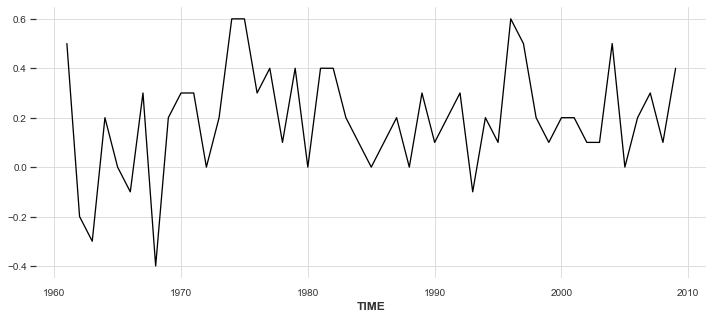

In [124]:
life_df1.plot()

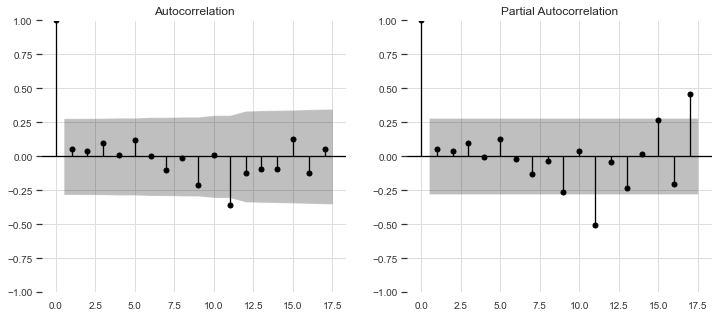

In [125]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]); plt.show()

In [132]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   40
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  -5.166
Date:                Fri, 09 Sep 2022   AIC                             14.333
Time:                        17:01:54   BIC                             17.660
Sample:                             0   HQIC                            15.526
                                 - 40                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3344      0.149      2.241      0.025       0.042       0.627
sigma2         0.0761      0.021      3.563      0.000       0.034       0.118
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.12   Prob(JB):                         0.54
Heteroskedasticity (H):               0.71   Skew:                            -0.44
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [135]:

(acorr_ljungbox(results.resid,lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

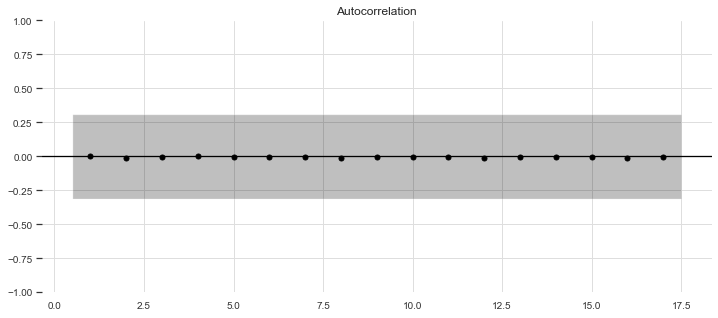

In [136]:
plot_acf(results.resid, zero=False);
plt.show()

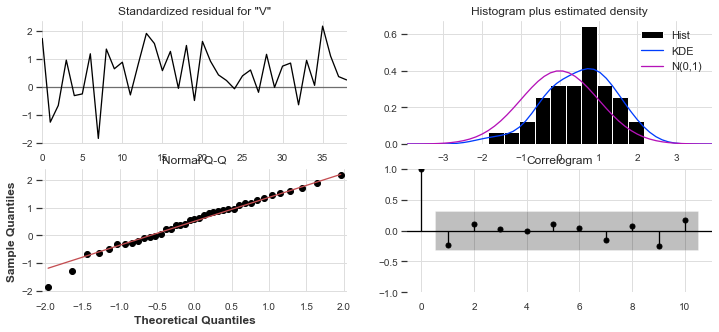

In [137]:
results.plot_diagnostics();
plt.show()

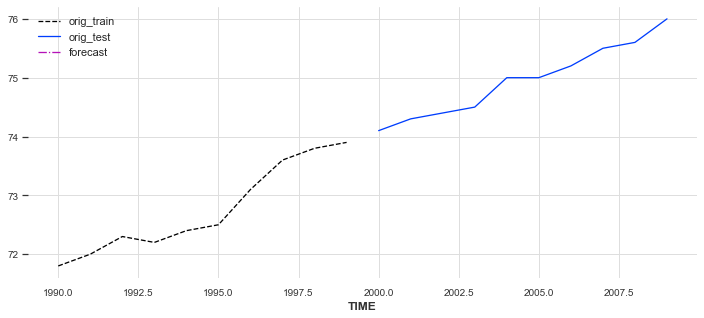

In [141]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()
plot_forecast(results,'1990', life_train, life_test)


In [142]:
pv, dv, qv = [list(range(3))]*3

In [143]:
vals = combinator([pv, dv, qv])

In [144]:
score = {}

In [150]:
for i, (p,d,q) in enumerate(vals):
    m = ARIMA(life_train, order = (p,d,q))
    res= m.fit()
    y = life_train.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic,
                'RMSPE': rmspe(y,y_hat),
                'BIC': res.bic,
                'AICc': res.aicc, 
                'MAPE': mape(y,y_hat),
                'model':res}

In [151]:
best_m = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: 143.16887658883707
Best model: 2 with lowest AIC score: 105.51162466200044
Best model: 3 with lowest AIC score: 18.094896420482783
Best model: 4 with lowest AIC score: 14.332645122206909
Best model: 5 with lowest AIC score: 13.92114506448851
Best model: 7 with lowest AIC score: 4.716507295915402


In [153]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,order,AIC,RMSPE,BIC,AICc,MAPE,model
0,7,"(0, 2, 1)",4.716507,1.260002,7.99168,5.059364,0.125776,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,13,"(1, 1, 1)",5.871351,1.050809,10.862036,6.557065,0.103427,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,16,"(1, 2, 1)",6.422635,1.154117,11.335394,7.128518,0.115007,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,8,"(0, 2, 2)",6.495622,1.168101,11.408381,7.201505,0.116447,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,14,"(1, 1, 2)",7.866636,1.062857,14.520883,9.043107,0.104848,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


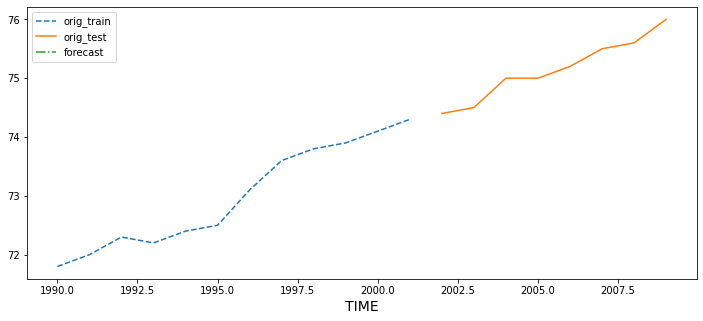

In [232]:
plot_forecast(best_m, '1990', life_train, life_test)

In [238]:
best_m

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

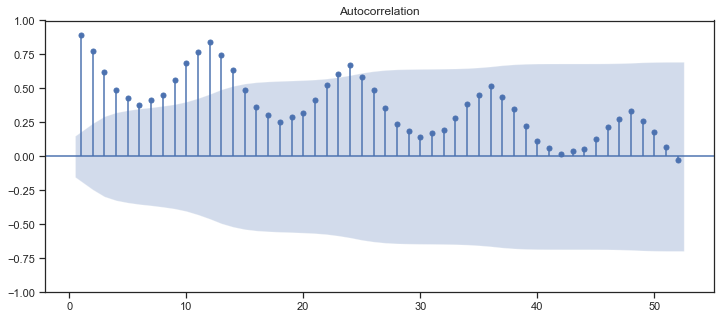

In [50]:
plot_acf(milk, lags=52, zero=False);plt.show()

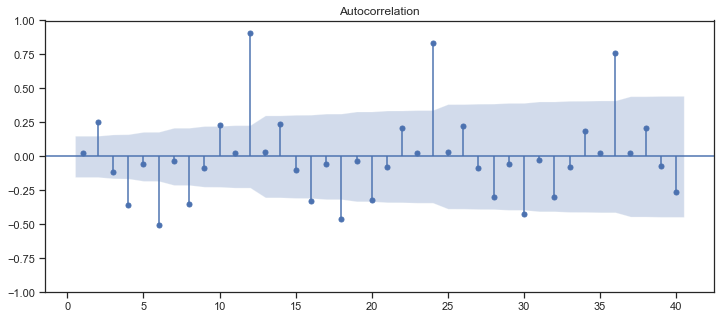

In [46]:
plot_acf(milk.diff(1).dropna(), lags=40,
         zero=False); plt.show()

In [51]:
len(milk)

168

'Stationary	 p-value:1.8654234318788898e-05 	 lags:11


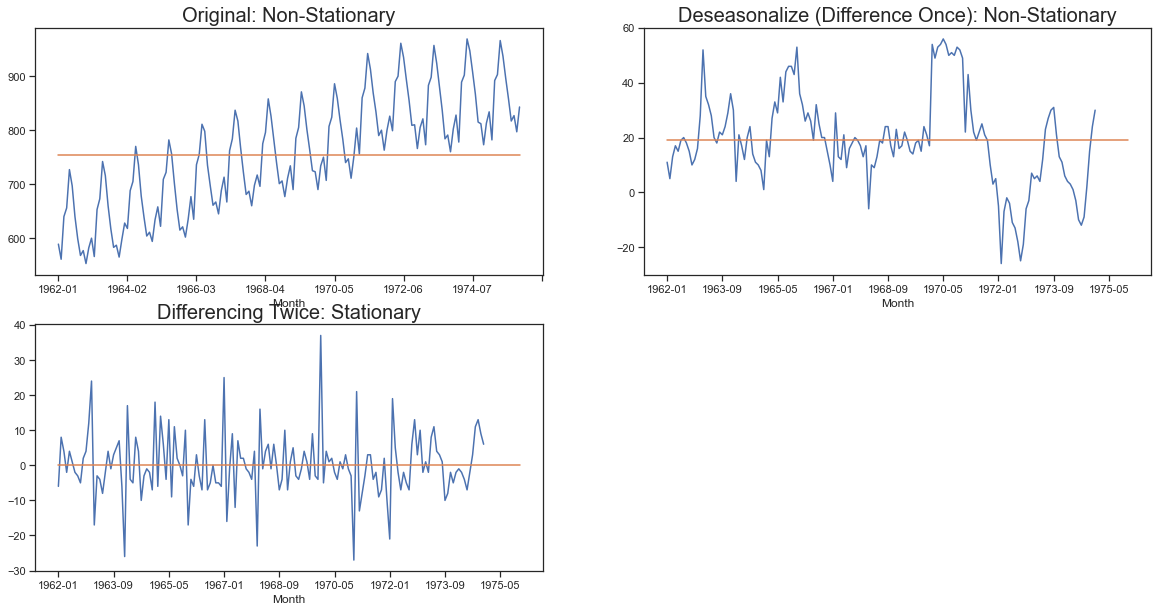

In [52]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize (Difference Once)', 'Differencing Twice']
fig, ax = plt.subplots(2,2, figsize=(20,10))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
plt.show() 

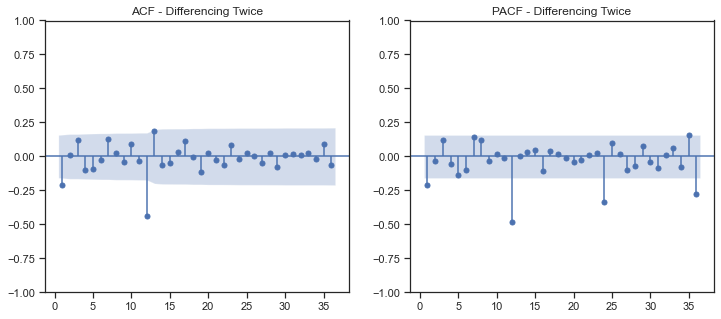

In [53]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

In [54]:
sarima_model = SARIMAX(milk_train,
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

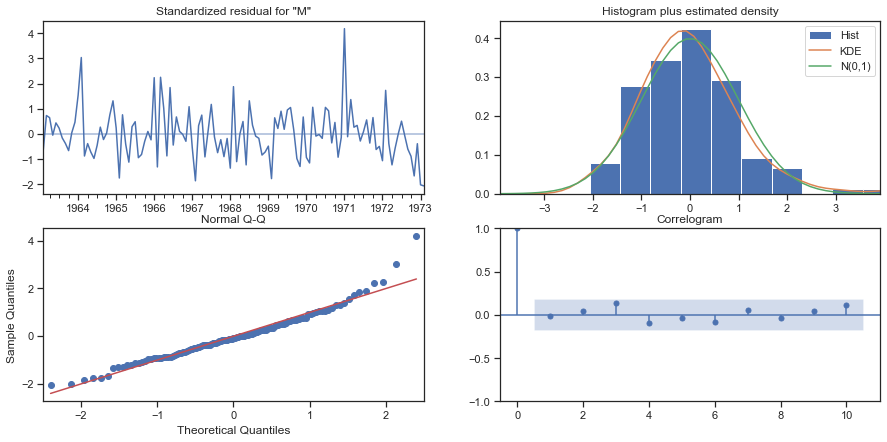

In [55]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [56]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Monthly_milk_production   No. Observations:                  134
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -418.834
Date:                            Thu, 25 Aug 2022   AIC                            843.667
Time:                                    13:54:47   BIC                            852.055
Sample:                                01-01-1962   HQIC                           847.074
                                     - 02-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2684      0.093     -2.888      0.004      -0.451      -0.086
ma.S.L12      -0.6304      0.090     -7.034      0.000      -0.806      -0.455
sigma2        56.4983      6.184      9.137      0.000      44.378      68.618
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                35.71
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.85
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

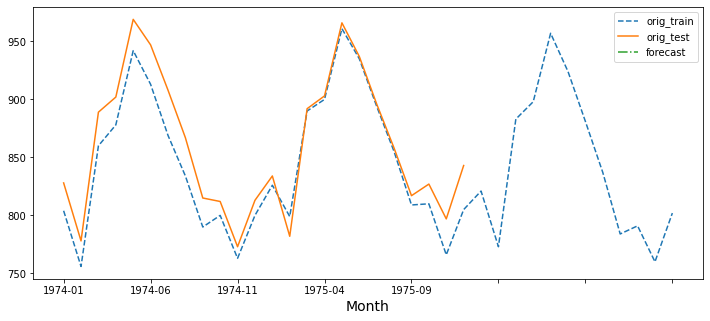

In [252]:
plot_forecast(model, '1971', milk_train, milk_test)

In [57]:
#SARIMAX optimisation

In [58]:
P_ns, D_ns, Q_ns = [list(range(3))]*3

In [59]:
P_s, D_s, Q_s = [list(range(2))]*3

In [60]:
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])

In [61]:
score = {}

In [65]:
for i , (p,d,q,P,D,Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, order =(p,d,q), seasonal_order =(P,D,Q, 12), enforce_stationarity=False)
    
    res = m.fit(disp=0)
    y = milk_test.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order':(p,d,q),
                 'seasonal order': (P,D,Q),
                 'AIC':res.aic,
                 'AICc':res.aicc,
                 'BIC':res.bic,
                 'RMSPE':rmse(y,y_hat), 
                 'MAPE':mape(y,y_hat), 
                 'model':res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)


In [66]:
best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: 1815.4630849759867
Best model: 2 with lowest AIC score: 1147.5598549872886
Best model: 3 with lowest AIC score: 1006.0593411556814
Best model: 5 with lowest AIC score: 971.6182996275587
Best model: 7 with lowest AIC score: 936.9883958268206
Best model: 11 with lowest AIC score: 921.0060006089877
Best model: 15 with lowest AIC score: 869.9883648181628
Best model: 23 with lowest AIC score: 845.5731583326892
Best model: 27 with lowest AIC score: 758.747878730044
Best model: 35 with lowest AIC score: 742.8619672969276
Best model: 43 with lowest AIC score: 735.6628650882608
Best model: 67 with lowest AIC score: 735.3531763627022


In [67]:
score[67]

{'non-seasonal order': (0, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 735.3531763627022,
 'AICc': 735.7531763627022,
 'BIC': 745.9690177633323,
 'RMSPE': 97.97372283715859,
 'MAPE': 0.09644848604533986,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1260910d0>}

In [69]:
#Best score function, BIC
def get_best_model_BIC(score, c='BIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score=v[c]
            best_model = k
            print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [70]:
best_model_BIC = get_best_model_BIC(score,'BIC')

Best model: 1 with lowest BIC score: 1821.0546660671803
Best model: 2 with lowest BIC score: 1150.3556455328853
Best model: 3 with lowest BIC score: 1011.4420369201397
Best model: 5 with lowest BIC score: 980.005671264349
Best model: 7 with lowest BIC score: 945.062439473508
Best model: 11 with lowest BIC score: 929.0523942903604
Best model: 15 with lowest BIC score: 880.7168897266597
Best model: 23 with lowest BIC score: 858.9373025049988
Best model: 27 with lowest BIC score: 764.1121411842925
Best model: 35 with lowest BIC score: 750.8804538003133
Best model: 43 with lowest BIC score: 746.3166214647091
Best model: 67 with lowest BIC score: 745.9690177633323


In [71]:
score[67]

{'non-seasonal order': (0, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 735.3531763627022,
 'AICc': 735.7531763627022,
 'BIC': 745.9690177633323,
 'RMSPE': 97.97372283715859,
 'MAPE': 0.09644848604533986,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1260910d0>}

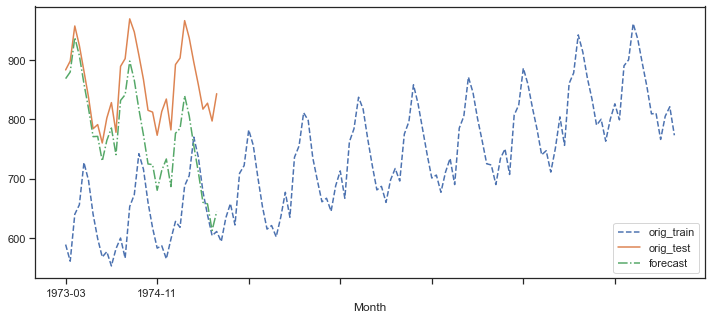

In [77]:
#plot_forecast(best_model,'1962', milk_train, milk_test)

In [75]:
milk_train

,Monthly_milk_production
Month,
1962-01,589.0
1962-02,561.0
1962-03,640.0
1962-04,656.0
1962-05,727.0
...,...
1972-10,810.0
1972-11,766.0
1972-12,805.0
